In [135]:
# !pip install annoy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import annoy
import pandas as pd
from collections import Counter

%load_ext autoreload
%autoreload 2
from ann_utils import ANN
from collections import Counter
import numpy as np
from annoy import AnnoyIndex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
embedding_path = 'embeddings_v5 (2).npy'
label_path = 'labels_v5 (2).npy'
filename_path = 'filenames.npy'

In [161]:
ann_v5 = ANN(embedding_path, label_path, filename_path, 7000)
ann_v5.supervised_evaluation(double_vote=False)

sub-track-classification acc: 73.0% 
top_2 sub-track-classification acc: 92.0%


In [ ]:
ann_v5.plot_tsne(size=1000) # how many random points you want to fit_transform 

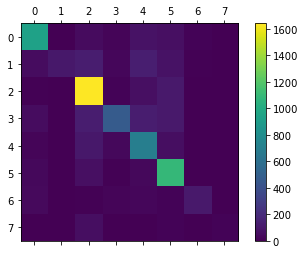

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ann_v5.confusion_matrix)
fig.colorbar(cax)
plt.show()

In [9]:
print(ann_v5.classification_report)

               precision    recall  f1-score   support

      Hip-Hop       0.81      0.80      0.80      1180
          Pop       0.95      0.20      0.33       550
         Folk       0.75      0.89      0.81      1850
 Experimental       0.77      0.52      0.62       900
         Rock       0.59      0.75      0.66       930
International       0.70      0.87      0.78      1250
   Electronic       0.70      0.47      0.56       240
 Instrumental       0.93      0.13      0.23       100

     accuracy                           0.73      7000
    macro avg       0.77      0.58      0.60      7000
 weighted avg       0.75      0.73      0.70      7000



In [179]:
catch_single = list()
catch_double = list()
catch_triple = list()
preds = {}

# snippet-song matching
for sample_vec, filename in zip(full_embeddings[:100], full_filenames[:100]):
    predictions = ann_v5.annoy_index.get_nns_by_vector(sample_vec, 10, include_distances=False)
    
    catch_single.append(filename == mc[0])
    catch_double.append(filename in mc[:2])
    catch_triple.append(filename in mc)

In [181]:
prec_single = (np.sum(catch_single)/len(catch_single)) * 100
print(f'top-1 song-matching: {np.round(prec_single, 2)}%')

top-1 song-matching: 77.0%


In [182]:
prec_double = (np.sum(catch_double)/len(catch_double)) * 100

print(f'top-2 song-matching: {np.round(prec_double, 2)}%')

top-2 song-matching: 91.0%


In [184]:
prec_triple = (np.sum(catch_triple)/len(catch_triple)) * 100

print(f'top-3 song-matching: {np.round(prec_triple, 2)}%')

top-3 song-matching: 98.0%


In [140]:
# 3 genres cm
v1 = np.where(full_labels == 0)[0]
v2 = np.where(full_labels == 1)[0]
v3 = np.where(full_labels == 4)[0]

idx = np.concatenate([v1, v2, v3])

relevant_embeddings = full_embeddings[idx]
relevant_labels = full_labels[idx]
relevant_filenames = full_filenames[idx]

relevant_embeddings.shape

(29960, 1024)

In [151]:
ann_v5.genre_names = ['Hip-Hop', 'Pop', 'Rock']

ann_v5.base_population = relevant_embeddings
ann_v5.labels = relevant_labels
ann_v5.filenames = relevant_filenames

# add population
ann_v5.annoy_index = AnnoyIndex(ann_v5.embedding_size, ann_v5.metric)
for sample_id, embedding in enumerate(ann_v5.base_population):
    ann_v5.annoy_index.add_item(sample_id, embedding)

In [153]:
# build 
ann_v5.annoy_index.build(ann_v5.n_trees)

True

In [160]:
ann_v5.supervised_evaluation(double_vote=False)
print(ann_v5.classification_report)

[[b'datasets/fma_small_wav/000/000002.wav']]


ValueError: Found input variables with inconsistent numbers of samples: [29960, 1]

In [156]:
idx_4 = np.where(ann_v5.labels == 4)
ann_v5.labels[idx_4[0]] = 2

from sklearn.metrics import confusion_matrix

unit_predictions = [pred[0] for pred in ann_v5.sub_predictions]
unit_predictions = np.array(unit_predictions)
unit_predictions[np.where(unit_predictions==4)[0]] = 2
ann_v5.confusion_matrix = confusion_matrix(ann_v5.labels, unit_predictions, labels=range(len(ann_v5.genre_names)))

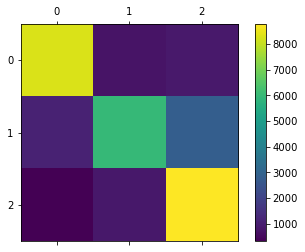

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ann_v5.confusion_matrix)
fig.colorbar(cax)
plt.show()